In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
#from commonfunctions import *
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.measure import find_contours
from skimage.draw import rectangle

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    # channel_count = img.shape[2]
    match_mask_color = (255)
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines):
    img = np.copy(img)
    blank_image = np.zeros((img.shape[0], img.shape[1], 3), np.uint8)

    for line in lines:
        for x1, y1, x2, y2 in line:
            if(abs(y1-y2)>40): # np.sqrt(np.sum([np.square(y2-y1),np.square(x2-x1)])) #Euclidean distance
                cv2.line(blank_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    img = cv2.addWeighted(img, 0.8, blank_image, 1, 0.0)
    return img

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def threshold(img):
    image=rgb2gray(img)
    global_thresh = threshold_otsu(image)
    binary_global = image > global_thresh
    return binary_global

def sobel_H_V_angles(img):
    gray_img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2GRAY)
    blur_img = gaussian_blur(gray_img, 9)
    sobelx = cv2.Sobel(src=blur_img, ddepth=cv2.CV_64F, dx=1, dy=0) # Sobel on the X axis
    sobelx = abs(sobelx) + 1
    sobely = cv2.Sobel(src=blur_img, ddepth=cv2.CV_64F, dx=0, dy=1) # Sobel on the Y axis
    sobely = abs(sobely) + 1
    angles = abs(sobely/sobelx) #np.arctan
    return sobelx, sobely, angles


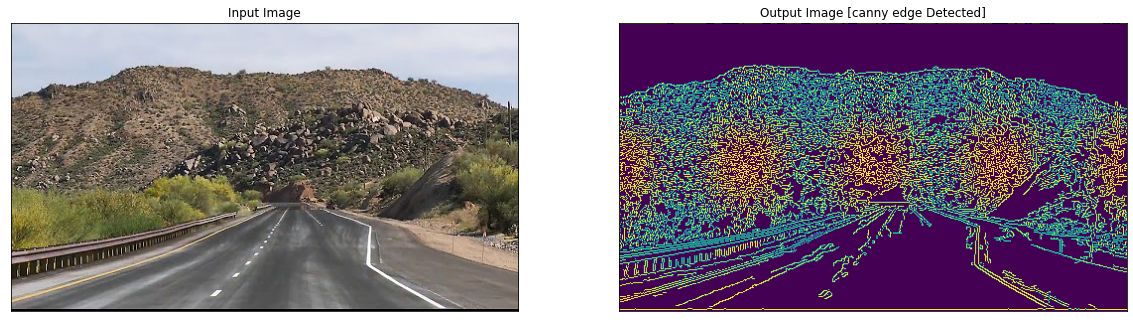

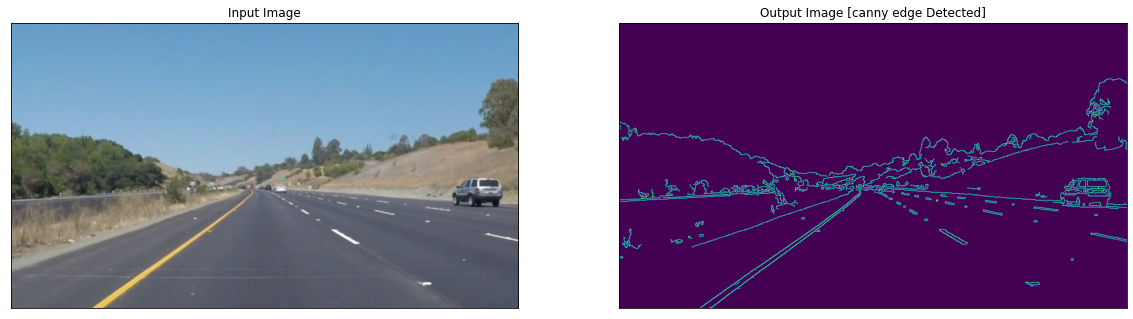

In [4]:

for image_path in list(os.listdir('./test_images')):
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'./test_images/{image_path}')
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input Image")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(cv2.Canny(image, 50, 200))
    ax.set_title("Output Image [canny edge Detected]")
    plt.show()

In [28]:
def textur_filtring_with_angles(image, edged_img, window_height, window_width, textur_threshold):
    result = np.copy(edged_img)
    half_height = window_height//2 # Y
    half_width = window_width//2 # X
    sobelx, sobely, angles = sobel_H_V_angles(image)
    # hist_var = []
    # print(angles)
    for i in range(half_height, result.shape[0] - half_height - 10):
        for j in range(half_width, result.shape[1] - half_width):
            # mean = np.average(angles[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)])
            # var = np.average((angles[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)] - mean)**2)
            min_angle = np.min(angles[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)])
            max_angle = np.max(angles[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)])
            # hist_var = hist_var + [max_angle - min_angle]
            # print(max_angle - min_angle)
            # print(var)
            if(max_angle - min_angle > textur_threshold):
                result[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)] = 0
    return result

def textur_filtring_with_magnitude(image, edged_img, window_height, window_width, textur_threshold):
    result = np.copy(edged_img)
    half_height = window_height//2 # Y
    half_width = window_width//2 # X
    for i in range(half_height, result.shape[0] - half_height - 10):
        for j in range(half_width, result.shape[1] - half_width):
            if(np.sum(edged_img[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)] > 0) > textur_threshold):
                result[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)] = 0
    return result


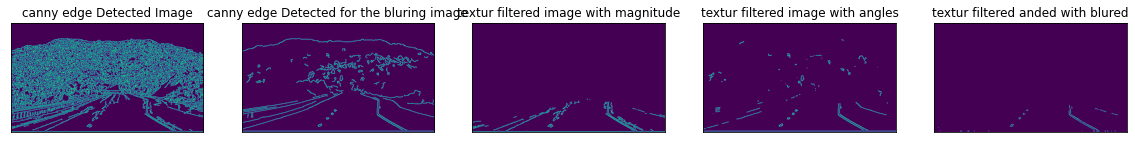

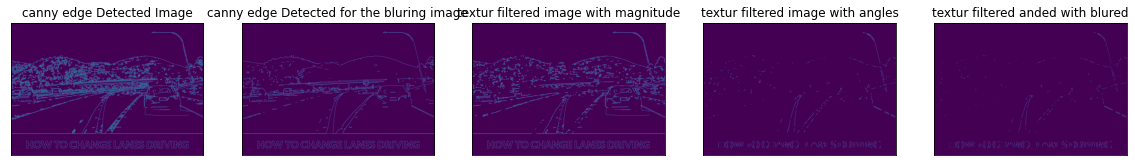

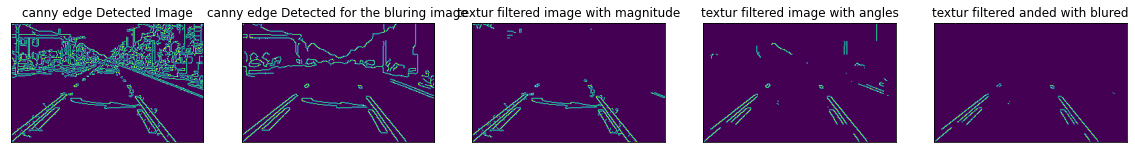

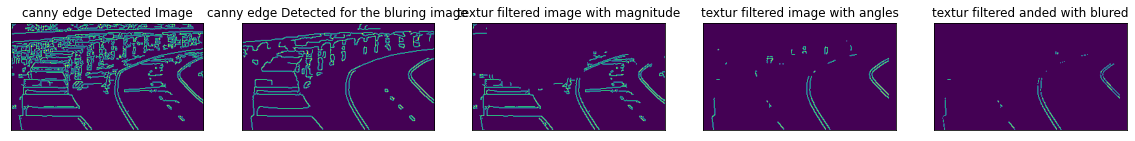

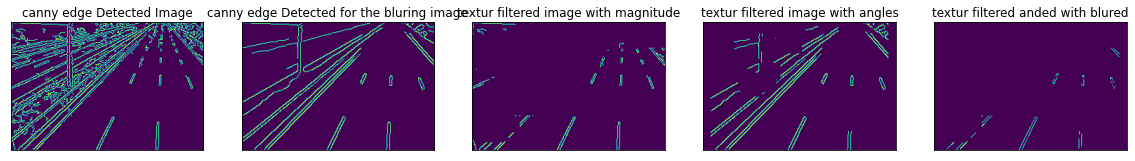

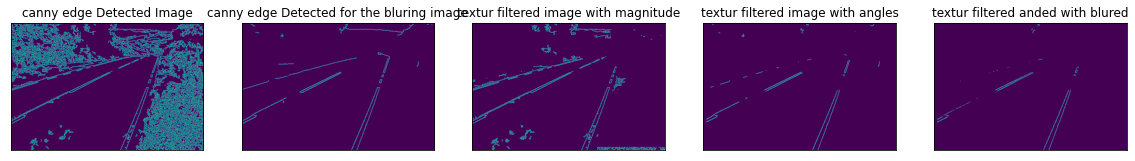

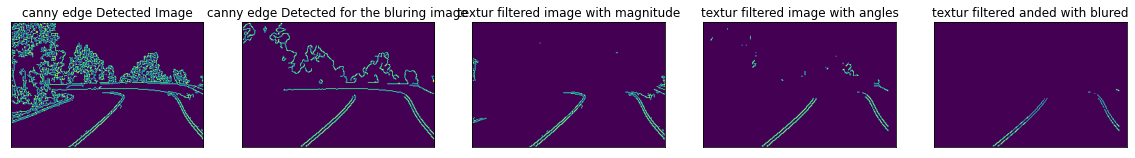

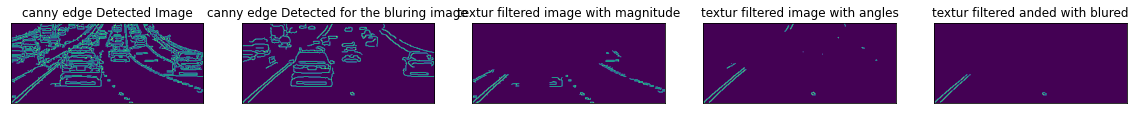

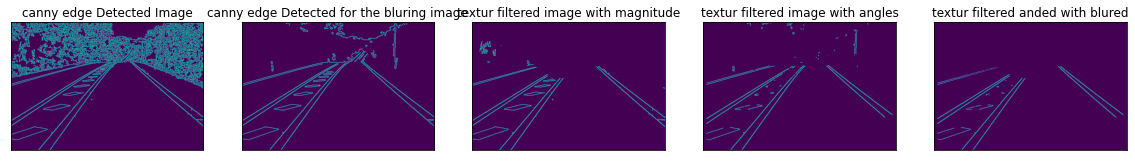

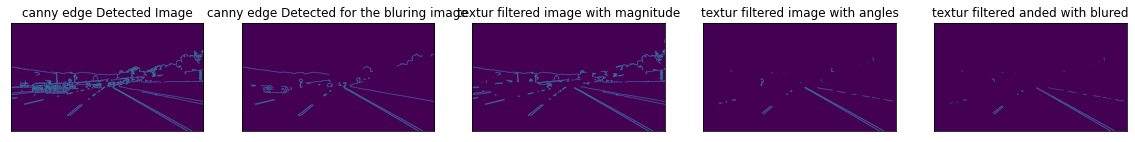

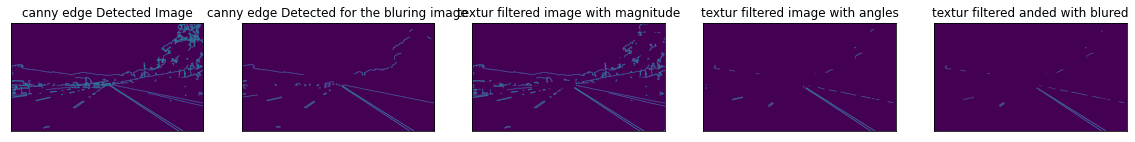

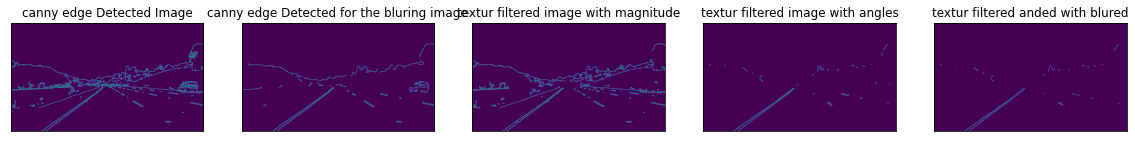

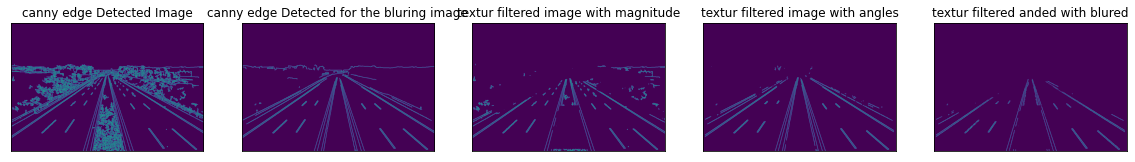

In [30]:
from skimage.filters import gaussian
for image_path in list(os.listdir('./test_images')):
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'./test_images/{image_path}')
    ax = fig.add_subplot(1, 5, 1,xticks=[], yticks=[])
    edge = cv2.Canny(image, 50, 200, apertureSize=3)
    plt.imshow(edge)
    ax.set_title("canny edge Detected Image")
    ########################################################################
    blur_img = gaussian_blur(image, 7)
    blur_edged = cv2.Canny(blur_img, 100, 200, apertureSize=3)
    ax = fig.add_subplot(1, 5, 2,xticks=[], yticks=[])
    plt.imshow(blur_edged)
    ax.set_title("canny edge Detected for the bluring image")
    ########################################################################
    ax = fig.add_subplot(1, 5, 3,xticks=[], yticks=[])
    filtered_image_with_magnitude = textur_filtring_with_magnitude(image, edge, 20, 40, 200) #try 200 or 150
    plt.imshow(filtered_image_with_magnitude)
    ax.set_title("textur filtered image with magnitude")
    ########################################################################
    ax = fig.add_subplot(1, 5, 4,xticks=[], yticks=[])
    # num_of_edges = np.sum(edge/255 != 0)
    # mean = num_of_edges / (edge.shape[0]*edge.shape[1])
    filtered_image_with_angles = textur_filtring_with_angles(image, blur_edged, 10, 10, 40) #try 200 or 150
    plt.imshow(filtered_image_with_angles)
    ax.set_title("textur filtered image with angles")
    ########################################################################
    ax = fig.add_subplot(1, 5, 5,xticks=[], yticks=[])
    filter_and_blur = filtered_image_with_magnitude & filtered_image_with_angles & blur_edged
    plt.imshow(filter_and_blur)
    ax.set_title("textur filtered anded with blured")
    plt.show()
    # plt.figure()
    # plt.hist(var_hist, bins=range(0,len(var_hist)))
    # print(var_hist)
    

In [19]:
from skimage.exposure import histogram
from matplotlib.pyplot import bar
any_image = mpimg.imread(f'./test_images/images.jfif')
edge = cv2.Canny(any_image, 50, 200, apertureSize=3)
imgHist = np.zeros(256)
half_height = 20
half_width = 40
for i in range(half_height, edge.shape[0] - half_height):
    for j in range(half_width, edge.shape[1] - half_width):
        mean = np.average(edge[(i - half_height) : (i + half_height + 1), (j - half_width) : (j + half_width + 1)])
        imgHist[mean.astype(np.uint8)] = imgHist[mean.astype(np.uint8)] + 1

# num_of_edges = np.sum(edge != 0)
# mean = num_of_edges / (edge.shape[0]*edge.shape[1])
# print(num_of_edges)
# print(mean)
imgHist[0] = 0
plt.hist(imgHist[0:255], bins=range(10,(2 ** 8)))
plt.figure()
filtered_image = textur_filtring(any_image, edge, 20, 40, 140)
io.imshow(filtered_image)
io.show()



FileNotFoundError: [Errno 2] No such file or directory: './test_images/images.jfif'

In [ ]:
# paramters we can play with 
# 1) kernel_size in blur 
# 2) region_of_interest_vertices 
# 3)thresould1 
# 4) thresould2 
# 5) put condtion on line
def lanesDetection(img):

    # print(img.shape)
    height = img.shape[0]
    width = img.shape[1]
    
    ###
    binary_image=threshold(img)
    number_of_white_pix = np.sum(binary_image == 1)
    number_of_black_pix = np.sum(binary_image == 0)
    print(number_of_white_pix,number_of_black_pix)
    if(number_of_white_pix/number_of_black_pix > .8):
        ratio=.8
    else:
        ratio=number_of_white_pix/number_of_black_pix
    ###

    # region_of_interest_vertices = [
    #     (0, height), (width, height),(width, height*.85),(width*.7,height*ratio),(width*.3,height*ratio),(0, height*.85)
    # ]
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    smoothed_img = gaussian_blur(img = gray_img, kernel_size = 9)
    edge = cv2.Canny(smoothed_img, 50, 100, apertureSize=3)
    cropped_image = textur_filtring(img, edge, 20, 40).astype('uint8')

    lines = cv2.HoughLinesP(cropped_image, rho=2, theta=np.pi/180,
                           threshold=50, lines=np.array([]), minLineLength=10, maxLineGap=30).astype('uint8')
    image_with_lines = draw_lines(img, lines)
    return image_with_lines


NameError: name 'threshold_otsu' is not defined

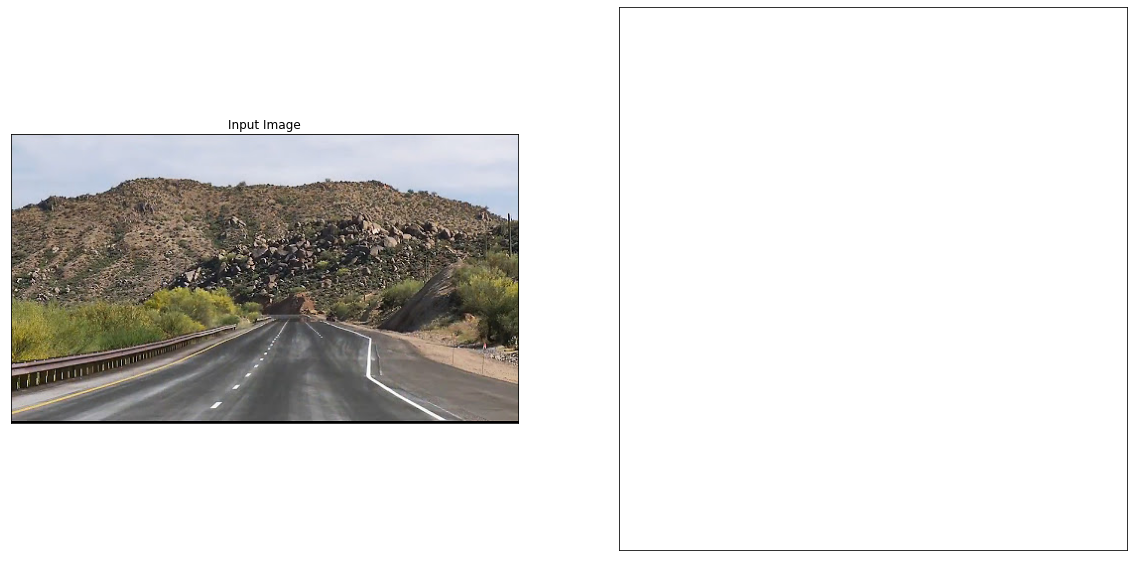

In [ ]:
for image_path in list(os.listdir('./test_images')):
    fig = plt.figure(figsize=(20, 10))
    image = mpimg.imread(f'./test_images/{image_path}')
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title("Input Image")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(lanesDetection(image))
    ax.set_title("Output Image [Lane Line Detected]")
    plt.show()